### This jupyter notebook is a condensation of Will Roscoe's code for the training of donkeycar data.
This is a much smaller version and may be easier to follow for beginners.

In [1]:
"""
Pull in required libraries
"""
from donkeycar.parts.keras import KerasLinear, default_linear
from donkeycar.parts.datastore import TubGroup
import IPython.display
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.python.keras.layers import Input, Convolution2D, Dropout, Flatten, Dense, MaxPooling2D
from tensorflow.python.keras.models import Model

using donkey version: 2.5.7 ...


The next cell reads the data and puts it in a form to be processed by the training function.  Since the data
files are big, the training function processes batches of moderate size at a time.  The function train_generator
serves up a tensor, X, of input images and a tensor, Y, of steering, throttle values each time it is called.

In [2]:
new_model_path = '/Users/cmasenas/mycar/models/newmodel2'   # modify as necessary
base_model_path = '/Users/cmasenas/mycar/models/mypilot'
tubgroup = TubGroup('/Users/cmasenas/mycar/tub')

BATCH_SIZE = 128
TRAIN_TEST_SPLIT = 0.8
IMAGE_SCALE = 255 # this should be either 1 (unscaled image) or 255 (scaled)
SHUFFLE = True

X_keys = ['cam/image_array']
y_keys = ['user/angle', 'user/throttle']

df = tubgroup.df[X_keys + y_keys]  # dataframe including only image, angle, throttle

# next line produces a pandas dataframe for training 
if SHUFFLE == True:
    train_df = df.sample(frac=TRAIN_TEST_SPLIT, random_state=200)  # shuffles rows
else:
    train_df = df[:int(len(df)*TRAIN_TEST_SPLIT)]    # does not shuffle rows
# next line produces a pandas dataframe for validation
val_df = df.drop(train_df.index)
print('train length:', len(train_df), 'validation length: ', len(val_df))
        
def record_generator(df):
    '''This function grabs a dataframe (df) row each time next(record)
    is called in the batch_generator function'''
    while True:
        record = {}
        for index, row in df.iterrows():   
            record = row
            for key in X_keys:    # replace image file name values with image array values
                record[key] =  np.array(cv2.imread(row[key])) / IMAGE_SCALE
                #record[key] =  np.array(Image.open(row[key])) / IMAGE_SCALE
            yield record    # 'record' is a dictionary holding one image, one angle, and one throttle value
            
def batch_generator(df): 
    '''This function produces a dictionary.
    Keys are defined in X_keys and y_keys.
    Values are arrays of length BATCH_SIZE from record values ''' 
    record = record_generator(df)
    while True:
        record_list = [ next(record) for _ in range(BATCH_SIZE) ]  # this line produces batch of dictionary records
        batch_arrays = {}
        for _ , key in enumerate( X_keys + y_keys ):   # this loop produces an array for each key in X_keys + y_keys
            arr = np.array([r[key] for r in record_list ])               
            batch_arrays[key] = arr
        yield batch_arrays     # a dictionary with X_keys + y_keys and arrays as values 
              
def train_generator(df):
    '''Produces a tuple: X_key arrays, y_key arrays
    first tuple value: 4D array (array of 3D images)
    second tuple value: 2D array (1D steering values, 1D throttle values) '''
    batch_gen = batch_generator(df) 
    while True:
        batch = next(batch_gen)
        X = [batch[k] for k in X_keys]
        Y = [batch[k] for k in y_keys]
        yield X, Y   # a tuple of X_key arrays, y_key arrays



train length: 3610 validation length:  903


The below test_model can be modified for experimentation.

In [3]:
def test_model():
    img_in = Input(shape=(120, 160, 3), name='img_in')
    x = img_in

    # Convolution2D class name is an alias for Conv2D
    x = Convolution2D(filters=24, kernel_size=(5, 5), strides=(2, 2), activation='relu')(x)
    x = Convolution2D(filters=32, kernel_size=(5, 5), strides=(2, 2), activation='relu')(x)
    x = Convolution2D(filters=64, kernel_size=(5, 5), strides=(2, 2), activation='relu')(x)
    x = Convolution2D(filters=64, kernel_size=(3, 3), strides=(2, 2), activation='relu')(x)
    x = Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu')(x)

    x = Flatten(name='flattened')(x)
    x = Dense(units=100, activation='linear')(x)
    x = Dropout(rate=.1)(x)
    x = Dense(units=50, activation='linear')(x)
    x = Dropout(rate=.1)(x)
    # categorical output of the angle
    angle_out = Dense(units=1, activation='linear', name='angle_out')(x)

    # continous output of throttle
    throttle_out = Dense(units=1, activation='linear', name='throttle_out')(x)

    model = Model(inputs=[img_in], outputs=[angle_out, throttle_out])

    model.compile(optimizer='adam',
                  loss={'angle_out': 'mean_squared_error',
                        'throttle_out': 'mean_squared_error'},
                  loss_weights={'angle_out': 0.9, 'throttle_out': 0.1})

    return model


The next cell does the training.

In [4]:
kl = KerasLinear(model = test_model())  # omitting the argument uses the default_linear model
history =   kl.train(train_generator(train_df),  
                     train_generator(val_df) ,  
                     saved_model_path=new_model_path,
                     steps = int(len(tubgroup.df) * TRAIN_TEST_SPLIT // BATCH_SIZE),
                     train_split = TRAIN_TEST_SPLIT,
                     epochs = 20)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
6/6 [==============================] - 2s 317ms/step - loss: 0.1584 - angle_out_loss: 0.1723 - throttle_out_loss: 0.0337

Epoch 00001: val_loss improved from inf to 0.15839, saving model to /Users/cmasenas/mycar/models/newmodel2
28/28 [==============================] - 19s 671ms/step - loss: 0.2713 - angle_out_loss: 0.2926 - throttle_out_loss: 0.0792 - val_loss: 0.1584 - val_angle_out_loss: 0.1723 - val_throttle_out_loss: 0.0337
Epoch 2/20
6/6 [==============================] - 2s 319ms/step - loss: 0.1274 - angle_out_loss: 0.1401 - throttle_out_loss: 0.0131

Epoch 00002: val_loss improved from 0.15839 to 0.12740, saving model to /Users/cmasenas/mycar/models/newmodel2
28/28 [======================

Epoch 18/20
6/6 [==============================] - 2s 321ms/step - loss: 0.0586 - angle_out_loss: 0.0649 - throttle_out_loss: 0.0024

Epoch 00018: val_loss improved from 0.06467 to 0.05864, saving model to /Users/cmasenas/mycar/models/newmodel2
28/28 [==============================] - 19s 693ms/step - loss: 0.0489 - angle_out_loss: 0.0535 - throttle_out_loss: 0.0079 - val_loss: 0.0586 - val_angle_out_loss: 0.0649 - val_throttle_out_loss: 0.0024
Epoch 19/20
6/6 [==============================] - 2s 312ms/step - loss: 0.0594 - angle_out_loss: 0.0659 - throttle_out_loss: 9.4083e-04

Epoch 00019: val_loss did not improve from 0.05864
28/28 [==============================] - 20s 697ms/step - loss: 0.0432 - angle_out_loss: 0.0472 - throttle_out_loss: 0.0072 - val_loss: 0.0594 - val_angle_out_loss: 0.0659 - val_throttle_out_loss: 9.4083e-04
Epoch 20/20
6/6 [==============================] - 2s 321ms/step - loss: 0.0563 - angle_out_loss: 0.0625 - throttle_out_loss: 0.0011

Epoch 00020: val_los

Take a look at the losses over epochs.

dict_keys(['loss', 'angle_out_loss', 'throttle_out_loss', 'val_loss', 'val_angle_out_loss', 'val_throttle_out_loss'])


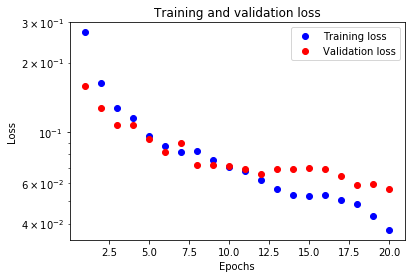

In [5]:
history_dict = history.history
print(history_dict.keys())

loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'ro', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.show()

## Predict steering and throttle from the model
Use the calculated model to produce predictions based on images.

In [6]:
fileseries = tubgroup.df['cam/image_array']
img_arr = []
for file in fileseries:
    image = cv2.imread(file)
    img_arr.append(image)
outputs = kl.model.predict(np.array(img_arr)/IMAGE_SCALE)
steering_prediction = outputs[0]
throttle_prediction = outputs[1]

The below scattergram of points displays measured vs predicted steering and throttle values.  
Ideally, predicted values should match measured values and points should fall on the red line 
indicating measured = predicted.

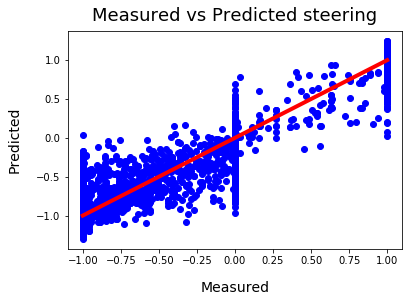

In [14]:
plt.title("Measured vs Predicted Steering", fontsize=18, y=1.02)
plt.xlabel("Measured", fontsize=14, labelpad=15)
plt.ylabel("Predicted", fontsize=14, labelpad=15)
plt.plot(tubgroup.df['user/angle'], steering_prediction.flatten(),'bo')
plt.plot([-1,1],[-1,1],'r', linewidth = 4)
plt.show()

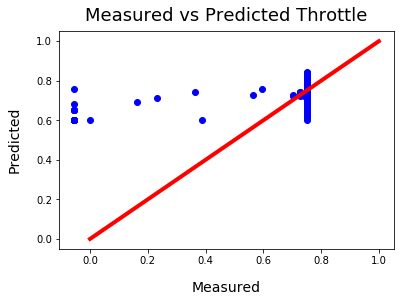

In [15]:
plt.title("Measured vs Predicted Throttle", fontsize=18, y=1.02)
plt.xlabel("Measured", fontsize=14, labelpad=15)
plt.ylabel("Predicted", fontsize=14, labelpad=15)
plt.plot(tubgroup.df['user/throttle'], throttle_prediction.flatten(),'bo')
plt.plot([0,1],[0,1],'r', linewidth = 4)
plt.show()